In [1]:
# Importing Reuqired Modules
import numpy as np
import matplotlib.pyplot as plt
import math
import torchvision
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.model_selection import train_test_split
from datetime import timedelta
from datetime import datetime
import copy
! pip install pytse_client
from collections import namedtuple, deque
import pytse_client as tse
import itertools
! pip install mpl_finance
from mpl_finance import candlestick_ohlc
import pandas as pd
import matplotlib.dates as mpl_dates
from pandas_datareader import data
import fix_yahoo_finance as yf
! pip install googlefinance
! pip install get-all-tickers
! pip install yahoofinancials
import pandas as pd
import datetime
from datetime import date
import random
import googlefinance
from get_all_tickers import get_tickers as gt
#set manual seed
def manual_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    from torch.backends import cudnn
    cudnn.deterministic = True #type: ignore
    cudnn.benchmark = False # type: ignore

manual_seed(2045)
seed = 2045

In [2]:
high_tickers = ['AMD', 'URI', 'FCX', 'DVN', 'SIVB', 'IPGP']
low_tickers = ['EGOV', 'VIVO', 'OMI', 'LAKE', 'POR', 'NEM']

In [3]:
print(torch.cuda.get_device_name(0))
if (torch.cuda.is_available()):
    device = 'cuda'
else:
    device = 'cpu'
print(device)

Tesla T4
cuda


In [4]:
all_high_beta = [] 
all_low_beta = []
for i in range(len(high_tickers)):
    symbol = low_tickers[i]
    data_source='google'
    start_date = '2016-02-20'
    end_date = '2021-02-22'
    df = data.get_data_yahoo(symbol, start_date, end_date)
    df = df.reset_index()
    print(len(df), low_tickers[i])
    all_low_beta.append(df)
    symbol = high_tickers[i]
    data_source='google'
    df = data.get_data_yahoo(symbol, start_date, end_date)
    df = df.reset_index()
    all_high_beta.append(df)
    print(len(df), high_tickers[i])


1260 EGOV
1260 AMD
1260 VIVO
1260 URI
1260 OMI
1260 FCX
1260 LAKE
1260 DVN
1260 POR
1260 SIVB
1260 NEM
1260 IPGP


In [5]:
df.isnull().any()

Date         False
High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool

In [6]:
all_high_beta[0] 

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-02-22,2.040000,1.930000,1.940000,2.010000,9895500,2.010000
1,2016-02-23,2.060000,1.970000,2.040000,1.970000,6710600,1.970000
2,2016-02-24,2.040000,1.930000,1.980000,2.020000,6906200,2.020000
3,2016-02-25,2.040000,1.980000,2.020000,2.030000,5614400,2.030000
4,2016-02-26,2.100000,2.030000,2.040000,2.070000,7911500,2.070000
...,...,...,...,...,...,...,...
1255,2021-02-16,94.000000,90.750000,93.900002,91.459999,35051400,91.459999
1256,2021-02-17,90.959999,88.570000,90.559998,89.940002,32245500,89.940002
1257,2021-02-18,89.599998,87.309998,89.089996,88.639999,35588700,88.639999
1258,2021-02-19,90.419998,88.690002,89.750000,89.580002,29526400,89.580002


In [7]:
len(all_high_beta)

6

In [8]:
high_ind = list(range(len(high_tickers)))
low_ind = list(range(len(low_tickers)))
c = list(itertools.product(high_ind, low_ind))

In [9]:
len(c)

36

In [10]:
y = list(range(36))
c_train, c_test, _, _ = train_test_split(c, y, test_size=0.2, random_state=2045)

In [11]:
print(len(c_train), len(c_test))
dates = df['Date']
dates

28 8


0      2016-02-22
1      2016-02-23
2      2016-02-24
3      2016-02-25
4      2016-02-26
          ...    
1255   2021-02-16
1256   2021-02-17
1257   2021-02-18
1258   2021-02-19
1259   2021-02-22
Name: Date, Length: 1260, dtype: datetime64[ns]

In [12]:
all_combs_train = []
all_combs_test = []
train_symbols = []
test_symbols = []
for comb in c_train:
    highI = comb[0]
    lowI = comb[1]
    high = all_high_beta[highI]
    low = all_low_beta[lowI]
    all_combs_train.append((np.array(high['Adj Close']),np.array(low['Adj Close'])))
    train_symbols.append((high_tickers[highI], low_tickers[lowI]))
for comb in c_test:
    highI = comb[0]
    lowI = comb[1]
    high = all_high_beta[highI]
    low = all_low_beta[lowI]
    all_combs_test.append((np.array(high['Adj Close']),np.array(low['Adj Close'])))
    test_symbols.append((high_tickers[highI], low_tickers[lowI]))
train_portfolios = all_combs_train
test_portfolios = all_combs_test

In [13]:
len(all_combs_train[0][0])

1260

# Environment

In [14]:

class WallStreet():
    def __init__(self, n, actions, portfolios, test_portfolios, symbols, symbols_test, initial_cash, penalty, init_ratio):
        self.state_dim = n*2+4
        self.n_actions = len(actions)
        self.commision = 0.001
        self.portfolios = portfolios
        self.portfolios_test = test_portfolios
        self.symbols_test = symbols_test
        self.penalty = penalty
        self.init_ratio = init_ratio
        self.high_symbol = None
        self.low_symbol = None
        self.symbols = symbols
        self.n = n
        self.initial_cash = initial_cash
        self.mapping_actions = [i for i in range(self.n_actions)]
        self.possible_actions = dict(zip(self.mapping_actions, actions))
        self.state = np.zeros(self.state_dim)
        self.time_step = 1
        self.max_time_step = int(len(portfolios[0][0])/n)
        self.all_rewards = []
        self.total_vals = []
        self.high_beta = None
        self.low_beta = None
        self.sharpes = []
    def reset(self, portfolio_ind=0, test=False, train_chosen=False):
        self.total_vals = []
        self.state = np.zeros(self.state_dim)
        if test==True:
            num = portfolio_ind  
            self.high_beta = self.portfolios_test[num][0]
            self.low_beta = self.portfolios_test[num][1]
            self.high_symbol = self.symbols_test[num][0]
            self.low_symbol = self.symbols_test[num][1]
        elif train_chosen == True:
            num = portfolio_ind
            self.high_beta = self.portfolios[num][0]
            self.low_beta = self.portfolios[num][1]
            self.high_symbol = self.symbols[num][0]
            self.low_symbol = self.symbols[num][1]
        else:
            num = np.random.choice(list(range(len(self.portfolios))))  
            self.high_beta = self.portfolios[num][0]
            self.low_beta = self.portfolios[num][1]
            self.high_symbol = self.symbols[num][0]
            self.low_symbol = self.symbols[num][1]
        self.sharpes = []
        #num = np.random.uniform()
        num = self.init_ratio
        low_val = num*self.initial_cash
        high_val = (1-num)*self.initial_cash
        low_num = int(low_val/(self.low_beta[0]))
        high_num = int(high_val/(self.high_beta[0]))
        total_value = high_num*self.high_beta[0]+low_num*self.low_beta[0]
        left_cash = self.initial_cash-total_value
        self.state[-4] = high_num        
        self.state[-3] = low_num
        self.state[-2] = total_value
        self.state[-1] = left_cash
        self.state[:n] = self.high_beta[:n]
        self.state[n:2*n] = self.low_beta[:n]
        self.time_step = 1
        self.all_rewards = []
        self.sharpe = 0
        self.sharpes.append(self.sharpe)
        self.total_vals.append(self.state[-2])
        return self.state
    def step(self, action):
        done = False
        next_state_low = self.low_beta[(self.time_step*self.n):(self.time_step+1)*self.n]
        next_state_high = self.high_beta[(self.time_step*self.n):(self.time_step+1)*self.n]
        self.time_step += 1
        #print(len(next_state_low))
        a = action
        if a>0:
            ### pecentage portfolio
            sell = a*self.state[-2]
            low_sell_n = int(sell/self.state[self.n*2-1])
            buy_budget = low_sell_n*self.state[self.n*2-1]
            high_buy_n = int(buy_budget/self.state[self.n-1])
            buy = high_buy_n*self.state[self.n-1]
            if self.state[-3]-low_sell_n > 0:
                cash_dif = sell-buy
                self.state[-3] -= low_sell_n
                self.state[-4] += high_buy_n
                self.state[-1] += (cash_dif - self.commision*2)
            #print(low_sell_n, high_buy)
            ### percentage stock
            # low_sell_n = int(self.state[-3]*a)
            # low_sell = low_sell_n*self.state[self.n*2-1]
            # high_buy_n = int(low_sell/self.state[self.n-1])
            # high_buy = high_buy_n*self.state[self.n-1]
            #print(low_sell_n, high_buy)

        elif a<0:
            ### Percentage stock
            # high_sell_n = int(self.state[-4]*(-a))
            # high_sell = high_sell_n*self.state[self.n-1]
            # low_buy_n = int(high_sell/self.state[self.n*2-1])
            # low_buy = low_buy_n*self.state[self.n*2-1]
            sell = -a*self.state[-2]
            high_sell_n = int(sell/self.state[self.n-1])
            buy_budget = high_sell_n*self.state[self.n-1]
            low_buy_n = int(buy_budget/self.state[self.n*2-1])
            buy = low_buy_n*self.state[self.n*2-1]
            if self.state[-4]-high_sell_n > 0:
                cash_dif = sell-buy
                self.state[-3] += low_buy_n
                self.state[-4] -= high_sell_n
                self.state[-1] += (cash_dif - self.commision*2)
        self.state[:self.n] = next_state_high
        self.state[self.n:2*self.n] = next_state_low
        new_tot = next_state_low[-1]*self.state[-3]+next_state_high[-1]*self.state[-4]
        reward = new_tot-self.state[-2]
        self.state[-2] = new_tot
        self.total_vals.append(self.state[-2])
        #print(reward)
        self.all_rewards.append(reward)
        pen_reward = reward - self.penalty*np.std(self.all_rewards)
        #print(pen_reward)
        self.sharpe = np.mean(self.all_rewards)/np.std(self.all_rewards)
        self.sharpes.append(self.sharpe)
        if self.max_time_step == self.time_step:
            done = True
        return self.state, pen_reward, done
    def action_space_Sample(self):
        return np.random.choice(self.possible_actions)

# DQN Agent

In [17]:
class DQN(nn.Module):
    def __init__(self, state_dim, n_actions, seed, act=F.relu):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_dim, 128)
        self.dr1 = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(128)
        self.act1 = act
        self.layer2 = nn.Linear(128, 128) 
        self.dr2 = nn.Dropout(p=0.3)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = act
        self.layer4 = nn.Linear(128, n_actions) 
        self.dr3 = nn.Dropout(p=0.2)
        self.bn3 = nn.BatchNorm1d(128)
        self.act4 = F.sigmoid
        self.layer3 = nn.Linear(128, 128) 
        self.act3 = act

    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.dr1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)
        
        x = self.layer4(x)
        x = self.act4(x)
        
        return x

In [21]:
class ReplayBuffer():

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):

        return len(self.memory)

In [22]:
# np.range([1,4,6])
# last_layer = 0

In [23]:
class OracleOfUT():

    def __init__(self, env, gamma, seed):
        self.env = env
        self.state_size = env.state_dim
        self.action_size = env.n_actions
        self.seed = random.seed(seed)
        self.GAMMA = gamma
        self.qnetwork_main = DQN(self.state_size, self.action_size, seed).to(device)
        self.qnetwork_target = DQN(self.state_size, self.action_size, seed+1).to(device)
        self.optimizer = optim.Adam(self.qnetwork_main.parameters(), lr=LR,weight_decay=1e-1)
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                loss = self.learn(experiences, self.GAMMA)
                # if GAMMA < 1:
                #     self.GAMMA*1.01
                return loss, True
        return 0, False

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_main.eval()
        with torch.no_grad():
            action_values = self.qnetwork_main(state)

        self.qnetwork_main.train()
        beta = 1.0
        q_values = action_values.cpu().data.numpy()
        ### Boltzman
        #p_as = np.exp(beta * q_values)/np.sum(np.exp(beta * q_values))
        #num_act = 7
        #action_key = np.random.choice(a=num_act, p=p_as[0])
        #return action_key
        if random.random() > eps:
            action = np.argmax(action_values.cpu().data.numpy())
        else:
            action = random.choice(np.arange(self.action_size))

        return action
    
    def action_test(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_main.eval()
        with torch.no_grad():
            action_values = self.qnetwork_main(state)
        #print(action_values)
        return np.argmax(action_values.cpu().data.numpy())


    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        rewards = (rewards-torch.mean(rewards))/(torch.max(rewards)-torch.min(rewards))
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_main(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_main, self.qnetwork_target, TAU)   
        return loss                  

    def soft_update(self, main_model, target_model, tau):
        last_layer = main_model.layer3.weight.cpu().detach().numpy()
        for target_param, main_param in zip(target_model.parameters(), main_model.parameters()):
            target_param.data.copy_(tau*main_param.data + (1.0-tau)*target_param.data)

#Training

In [24]:
n_actions = 7
actions = [-0.25, -0.1, -0.05, 0, 0.05, 0.1, 0.25]
n = 30
penalty = 0.0
initial_cash = 1e6
init_ratio = 0.5
state_dim = n*2+4
BUFFER_SIZE = int(1e6)
BATCH_SIZE = 32
GAMMA = 0.99        
TAU = 1e-3
LR = 1e-4
UPDATE_EVERY = 8

In [25]:

env = WallStreet(n, actions, train_portfolios, test_portfolios, train_symbols, test_symbols, initial_cash, penalty, init_ratio)
env.reset()
agent = OracleOfUT(env, GAMMA, seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
def train(n_episodes=500, max_t=100000, eps_start=1.0, eps_end=0.01, eps_decay=0.99):
    scores = []
    losses = []                       
    scores_window = deque(maxlen=10)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        loss = 0
        counter = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            a = env.possible_actions[action]
            next_state, reward, done = env.step(a)
            l, flag = agent.step(state, action, reward, next_state, done)
            if flag == True:
                loss += l
                counter += 1
            state = next_state
            score += reward
            if done:
                loss = loss/counter
                break 
        scores_window.append(score)
        scores.append(score)
        losses.append(loss)
        eps = max(eps_end, eps_decay*eps)
    return scores, losses
scores, losses = train()



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars


SIVB OMI
Episode 1
AMD EGOV
Episode 2
AMD VIVO
Episode 3
FCX LAKE
Episode 4
FCX LAKE
Episode 5
AMD VIVO
Episode 6
SIVB NEM
Episode 7
SIVB LAKE
Episode 8
FCX EGOV
Episode 9
URI EGOV
Episode 10
IPGP NEM
Episode 11
FCX EGOV
Episode 12
SIVB OMI
Episode 13
URI LAKE
Episode 14
URI LAKE
Episode 15
IPGP EGOV
Episode 16
AMD POR
Episode 17
SIVB VIVO
Episode 18
SIVB NEM
Episode 19
SIVB VIVO
Episode 20
FCX NEM
Episode 21
SIVB NEM
Episode 22
FCX LAKE
Episode 23
FCX VIVO
Episode 24
FCX POR
Episode 25
FCX EGOV
Episode 26
FCX LAKE
Episode 27
IPGP NEM
Episode 28
FCX OMI
Episode 29
DVN EGOV
Episode 30
AMD LAKE
Episode 31
IPGP NEM
Episode 32
AMD POR
Episode 33
AMD EGOV
Episode 34
URI LAKE
Episode 35
FCX VIVO
Episode 36
AMD VIVO
Episode 37
AMD OMI
Episode 38
FCX LAKE
Episode 39
FCX VIVO
Episode 40
IPGP OMI
Episode 41
IPGP VIVO
Episode 42
AMD POR
Episode 43
AMD OMI
Episode 44
SIVB LAKE
Episode 45
IPGP NEM
Episode 46
URI LAKE
Episode 47
FCX NEM
Episode 48
FCX VIVO
Episode 49
SIVB POR
Episode 50
SIVB VIVO
Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


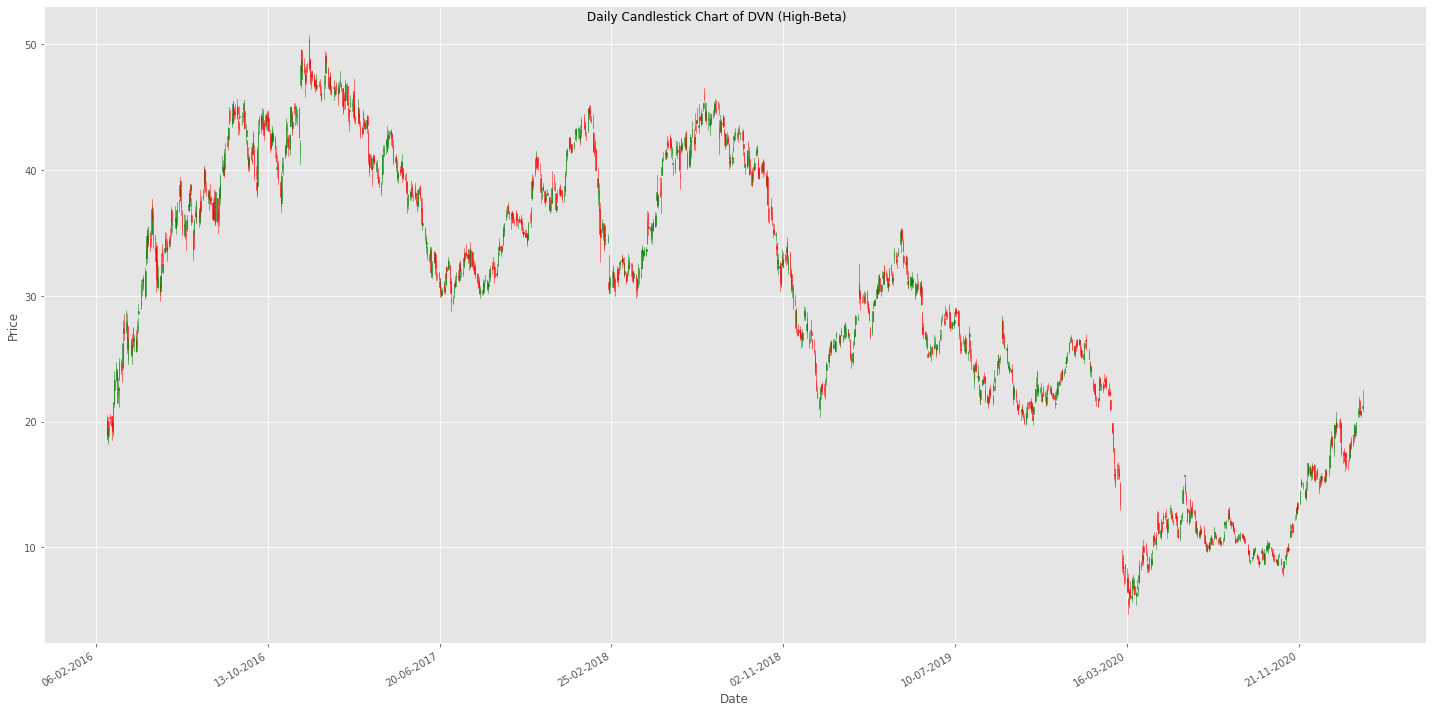

In [33]:
#df = all_high_beta[high_tickers.index(env.high_symbol)]
df = all_high_beta[high_tickers.index('DVN')]
plt.style.use('ggplot')
ohlc = df[['Date','Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots(figsize=(20,10))

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle(f'Daily Candlestick Chart of {high_tickers[high_tickers.index(env.high_symbol)]}')
fig.suptitle(f'Daily Candlestick Chart of {high_tickers[high_tickers.index("DVN")]} (High-Beta)')


# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


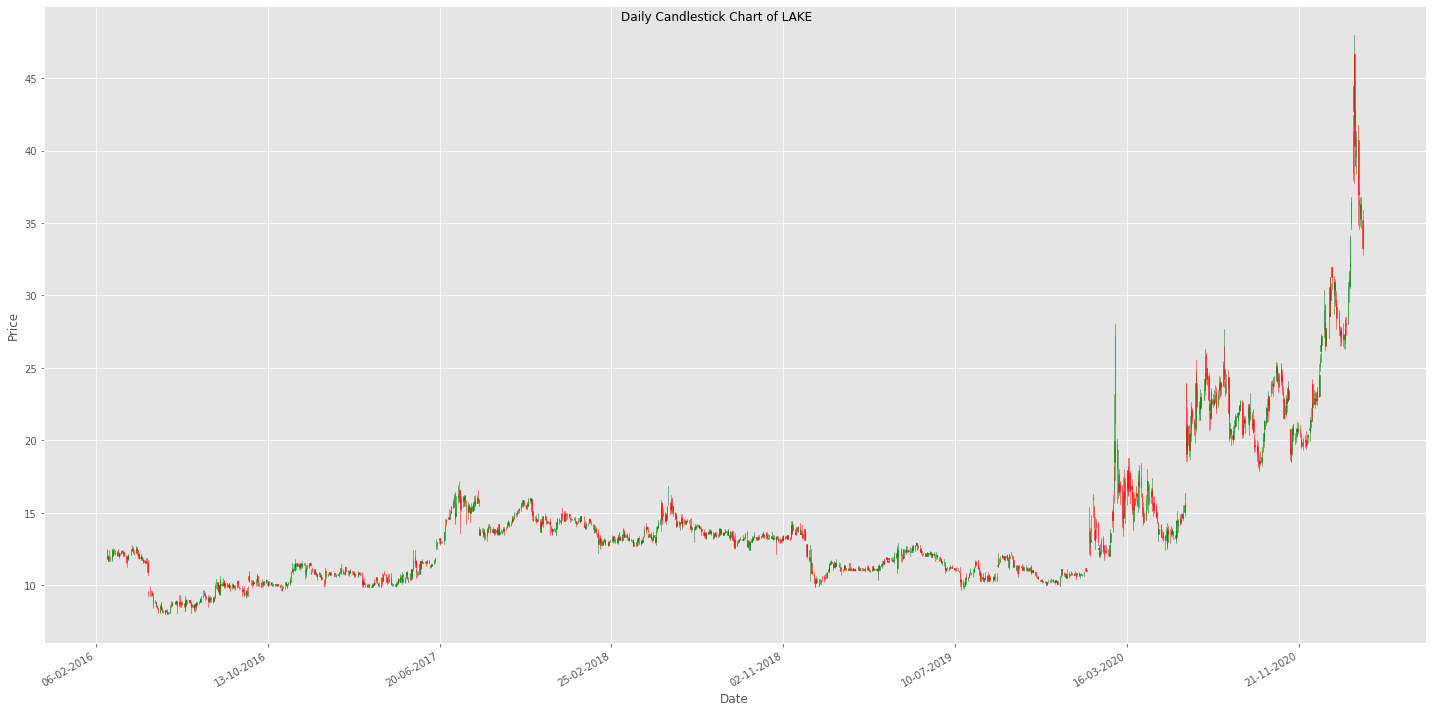

In [34]:
#df = all_low_beta[low_tickers.index(env.low_symbol)]
df = all_low_beta[low_tickers.index('LAKE')]

plt.style.use('ggplot')
ohlc = df[['Date','Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots(figsize=(20,10))

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle(f'Daily Candlestick Chart of {low_tickers[low_tickers.index(env.low_symbol)]}')
fig.suptitle(f'Daily Candlestick Chart of {low_tickers[low_tickers.index("LAKE")]}')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()